In [ ]:

# Load necessary libraries and data
import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Load the rule-based designs
rule_based_df = pd.read_csv('rule_based_designs.csv')
print(f"Loaded rule_based_designs.csv: {rule_based_df.shape}")
print(f"\nColumns: {list(rule_based_df.columns)}")
print(f"\nFirst few rows:")
print(rule_based_df.head())


Loaded rule_based_designs.csv: (90000, 5)

Columns: ['Scaffold', 'Loop_Position', 'Motif', 'Design_Sequence', 'MJ_Score']

First few rows:
  Scaffold  Loop_Position      Motif  \
0     1FNA             20  VPTKPTKKK   
1     1FNA             30  VPTKPTKKK   
2     1FNA             40  VPTKPTKKK   
3     1TEN             10  VPTKPTKKK   
4     1TEN             20  VPTKPTKKK   

                                     Design_Sequence  MJ_Score  
0  MQYKLILNGKTLKGETTTEAVPTKPTKKKVDAATAEKVFKQYANDN...    -113.6  
1  MQYKLILNGKTLKGETTTEAVDAATAEKVFVPTKPTKKKKQYANDN...    -113.6  
2  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDVPTKPT...    -113.6  
3       GSDTITNATIVPTKPTKKKKVQAPDYNVTAKAIGSLRAQACKVV    -113.6  
4       GSDTITNATIKVQAPDYNVTVPTKPTKKKAKAIGSLRAQACKVV    -113.6  


In [ ]:

# Step 1: Identify the top 5 unique motifs with the best (most negative) MJ scores
# Group by motif and get the best score for each
motif_scores = rule_based_df.groupby('Motif')['MJ_Score'].min().sort_values()
print(f"Total unique motifs: {len(motif_scores)}")
print(f"\nTop 5 motifs with best (most negative) MJ scores:")
top_5_motifs = motif_scores.head(5)
print(top_5_motifs)

# Extract the motif sequences
parent_motifs = list(top_5_motifs.index)
print(f"\nParent motifs for mutation:")
for i, motif in enumerate(parent_motifs, 1):
    print(f"{i}. {motif} (Score: {top_5_motifs[motif]})")


Total unique motifs: 10000

Top 5 motifs with best (most negative) MJ scores:
Motif
MGVVMMLTV   -237.56
VCILDCMVK   -235.28
RVCVPLVMC   -231.63
VKCVVCVVI   -230.22
LVIVILKLP   -229.10
Name: MJ_Score, dtype: float64

Parent motifs for mutation:
1. MGVVMMLTV (Score: -237.56000000000023)
2. VCILDCMVK (Score: -235.2799999999993)
3. RVCVPLVMC (Score: -231.62999999999985)
4. VKCVVCVVI (Score: -230.2199999999997)
5. LVIVILKLP (Score: -229.09999999999985)


In [ ]:

# Step 2: Define BLOSUM62 matrix for conservative mutations
# BLOSUM62 matrix (we'll use a simplified version for amino acids)
# We only need positive scores for conservative mutations

BLOSUM62 = {
    'A': {'A': 4, 'R': -1, 'N': -2, 'D': -2, 'C': 0, 'Q': -1, 'E': -1, 'G': 0, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 0, 'W': -3, 'Y': -2, 'V': 0},
    'R': {'A': -1, 'R': 5, 'N': 0, 'D': -2, 'C': -3, 'Q': 1, 'E': 0, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 2, 'M': -1, 'F': -3, 'P': -2, 'S': -1, 'T': -1, 'W': -3, 'Y': -2, 'V': -3},
    'N': {'A': -2, 'R': 0, 'N': 6, 'D': 1, 'C': -3, 'Q': 0, 'E': 0, 'G': 0, 'H': 1, 'I': -3, 'L': -3, 'K': 0, 'M': -2, 'F': -3, 'P': -2, 'S': 1, 'T': 0, 'W': -4, 'Y': -2, 'V': -3},
    'D': {'A': -2, 'R': -2, 'N': 1, 'D': 6, 'C': -3, 'Q': 0, 'E': 2, 'G': -1, 'H': -1, 'I': -3, 'L': -4, 'K': -1, 'M': -3, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -4, 'Y': -3, 'V': -3},
    'C': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': 9, 'Q': -3, 'E': -4, 'G': -3, 'H': -3, 'I': -1, 'L': -1, 'K': -3, 'M': -1, 'F': -2, 'P': -3, 'S': -1, 'T': -1, 'W': -2, 'Y': -2, 'V': -1},
    'Q': {'A': -1, 'R': 1, 'N': 0, 'D': 0, 'C': -3, 'Q': 5, 'E': 2, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 1, 'M': 0, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -2, 'Y': -1, 'V': -2},
    'E': {'A': -1, 'R': 0, 'N': 0, 'D': 2, 'C': -4, 'Q': 2, 'E': 5, 'G': -2, 'H': 0, 'I': -3, 'L': -3, 'K': 1, 'M': -2, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'G': {'A': 0, 'R': -2, 'N': 0, 'D': -1, 'C': -3, 'Q': -2, 'E': -2, 'G': 6, 'H': -2, 'I': -4, 'L': -4, 'K': -2, 'M': -3, 'F': -3, 'P': -2, 'S': 0, 'T': -2, 'W': -2, 'Y': -3, 'V': -3},
    'H': {'A': -2, 'R': 0, 'N': 1, 'D': -1, 'C': -3, 'Q': 0, 'E': 0, 'G': -2, 'H': 8, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -1, 'P': -2, 'S': -1, 'T': -2, 'W': -2, 'Y': 2, 'V': -3},
    'I': {'A': -1, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -3, 'E': -3, 'G': -4, 'H': -3, 'I': 4, 'L': 2, 'K': -3, 'M': 1, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -3, 'Y': -1, 'V': 3},
    'L': {'A': -1, 'R': -2, 'N': -3, 'D': -4, 'C': -1, 'Q': -2, 'E': -3, 'G': -4, 'H': -3, 'I': 2, 'L': 4, 'K': -2, 'M': 2, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -2, 'Y': -1, 'V': 1},
    'K': {'A': -1, 'R': 2, 'N': 0, 'D': -1, 'C': -3, 'Q': 1, 'E': 1, 'G': -2, 'H': -1, 'I': -3, 'L': -2, 'K': 5, 'M': -1, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'M': {'A': -1, 'R': -1, 'N': -2, 'D': -3, 'C': -1, 'Q': 0, 'E': -2, 'G': -3, 'H': -2, 'I': 1, 'L': 2, 'K': -1, 'M': 5, 'F': 0, 'P': -2, 'S': -1, 'T': -1, 'W': -1, 'Y': -1, 'V': 1},
    'F': {'A': -2, 'R': -3, 'N': -3, 'D': -3, 'C': -2, 'Q': -3, 'E': -3, 'G': -3, 'H': -1, 'I': 0, 'L': 0, 'K': -3, 'M': 0, 'F': 6, 'P': -4, 'S': -2, 'T': -2, 'W': 1, 'Y': 3, 'V': -1},
    'P': {'A': -1, 'R': -2, 'N': -2, 'D': -1, 'C': -3, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -4, 'P': 7, 'S': -1, 'T': -1, 'W': -4, 'Y': -3, 'V': -2},
    'S': {'A': 1, 'R': -1, 'N': 1, 'D': 0, 'C': -1, 'Q': 0, 'E': 0, 'G': 0, 'H': -1, 'I': -2, 'L': -2, 'K': 0, 'M': -1, 'F': -2, 'P': -1, 'S': 4, 'T': 1, 'W': -3, 'Y': -2, 'V': -2},
    'T': {'A': 0, 'R': -1, 'N': 0, 'D': -1, 'C': -1, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 5, 'W': -2, 'Y': -2, 'V': 0},
    'W': {'A': -3, 'R': -3, 'N': -4, 'D': -4, 'C': -2, 'Q': -2, 'E': -3, 'G': -2, 'H': -2, 'I': -3, 'L': -2, 'K': -3, 'M': -1, 'F': 1, 'P': -4, 'S': -3, 'T': -2, 'W': 11, 'Y': 2, 'V': -3},
    'Y': {'A': -2, 'R': -2, 'N': -2, 'D': -3, 'C': -2, 'Q': -1, 'E': -2, 'G': -3, 'H': 2, 'I': -1, 'L': -1, 'K': -2, 'M': -1, 'F': 3, 'P': -3, 'S': -2, 'T': -2, 'W': 2, 'Y': 7, 'V': -1},
    'V': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -2, 'E': -2, 'G': -3, 'H': -3, 'I': 3, 'L': 1, 'K': -2, 'M': 1, 'F': -1, 'P': -2, 'S': -2, 'T': 0, 'W': -3, 'Y': -1, 'V': 4}
}

def get_conservative_mutations(aa):
    """Return list of amino acids with BLOSUM62 score > 0 for the given amino acid"""
    if aa not in BLOSUM62:
        return []
    return [target_aa for target_aa, score in BLOSUM62[aa].items() if score > 0 and target_aa != aa]

# Test the function
print("Conservative mutations for M:", get_conservative_mutations('M'))
print("Conservative mutations for G:", get_conservative_mutations('G'))
print("Conservative mutations for V:", get_conservative_mutations('V'))


Conservative mutations for M: ['I', 'L', 'V']
Conservative mutations for G: []
Conservative mutations for V: ['I', 'L', 'M']


In [ ]:

# Generate all single and double conservative mutants for the 5 parent motifs
def generate_single_mutants(motif):
    """Generate all single conservative mutants"""
    mutants = []
    for i, aa in enumerate(motif):
        conservative_aas = get_conservative_mutations(aa)
        for new_aa in conservative_aas:
            mutant = motif[:i] + new_aa + motif[i+1:]
            mutants.append(mutant)
    return mutants

def generate_double_mutants(motif):
    """Generate all double conservative mutants"""
    mutants = []
    # Get all pairs of positions
    for i, j in combinations(range(len(motif)), 2):
        aa1 = motif[i]
        aa2 = motif[j]
        conservative_aas1 = get_conservative_mutations(aa1)
        conservative_aas2 = get_conservative_mutations(aa2)
        
        # Generate all combinations of conservative mutations at these positions
        for new_aa1 in conservative_aas1:
            for new_aa2 in conservative_aas2:
                mutant = list(motif)
                mutant[i] = new_aa1
                mutant[j] = new_aa2
                mutants.append(''.join(mutant))
    return mutants

# Generate all mutants for the top 5 motifs
all_mutants = {}
for motif in parent_motifs:
    single_mutants = generate_single_mutants(motif)
    double_mutants = generate_double_mutants(motif)
    all_mutants[motif] = {
        'single': single_mutants,
        'double': double_mutants
    }
    print(f"\nMotif: {motif}")
    print(f"  Single mutants: {len(single_mutants)}")
    print(f"  Double mutants: {len(double_mutants)}")
    print(f"  Total: {len(single_mutants) + len(double_mutants)}")

# Calculate total number of unique mutants
total_mutants = sum(len(all_mutants[motif]['single']) + len(all_mutants[motif]['double']) 
                    for motif in parent_motifs)
print(f"\nTotal mutants across all 5 parent motifs: {total_mutants}")



Motif: MGVVMMLTV
  Single mutants: 22
  Double mutants: 210
  Total: 232

Motif: VCILDCMVK
  Single mutants: 20
  Double mutants: 171
  Total: 191

Motif: RVCVPLVMC
  Single mutants: 17
  Double mutants: 120
  Total: 137

Motif: VKCVVCVVI
  Single mutants: 21
  Double mutants: 189
  Total: 210

Motif: LVIVILKLP
  Single mutants: 24
  Double mutants: 252
  Total: 276

Total mutants across all 5 parent motifs: 1046


In [ ]:

# Step 3: Create grafting function
# We need to understand the grafting positions from the existing data
# Let's examine how motifs were grafted in the rule_based_designs

def find_motif_position(design_seq, motif):
    """Find the position of a motif in a design sequence"""
    return design_seq.find(motif)

# Check a few examples to understand the grafting
print("Examining grafting patterns in rule_based_designs:")
for scaffold in ['1FNA', '1TEN', '2QMT']:
    scaffold_rows = rule_based_df[rule_based_df['Scaffold'] == scaffold].head(3)
    for idx, row in scaffold_rows.iterrows():
        motif = row['Motif']
        design = row['Design_Sequence']
        loop_pos = row['Loop_Position']
        motif_start = find_motif_position(design, motif)
        print(f"\n{scaffold} Loop {loop_pos}: Motif '{motif}' found at position {motif_start}")
        print(f"  Before: ...{design[max(0,motif_start-5):motif_start]}")
        print(f"  Motif:  {design[motif_start:motif_start+len(motif)]}")
        print(f"  After:  {design[motif_start+len(motif):motif_start+len(motif)+5]}...")
        break  # Just show one example per scaffold


Examining grafting patterns in rule_based_designs:

1FNA Loop 20: Motif 'VPTKPTKKK' found at position 20
  Before: ...TTTEA
  Motif:  VPTKPTKKK
  After:  VDAAT...

1TEN Loop 10: Motif 'VPTKPTKKK' found at position 10
  Before: ...TNATI
  Motif:  VPTKPTKKK
  After:  KVQAP...

2QMT Loop 15: Motif 'VPTKPTKKK' found at position 15
  Before: ...EHLGL
  Motif:  VPTKPTKKK
  After:  AESVE...


In [ ]:

# Extract scaffold information and create grafting function
# We'll use the existing design sequences to understand the scaffold structure

# Get scaffold templates by extracting from existing designs
scaffold_templates = {}
scaffold_loop_positions = {
    '1FNA': [20, 30, 40],
    '1TEN': [10, 20, 30],
    '2QMT': [15, 25, 35]
}

# For each scaffold, get a template sequence
for scaffold in ['1FNA', '1TEN', '2QMT']:
    # Get the first design for this scaffold
    first_design = rule_based_df[rule_based_df['Scaffold'] == scaffold].iloc[0]
    template_seq = first_design['Design_Sequence']
    motif = first_design['Motif']
    
    # Replace the motif with a placeholder
    motif_start = template_seq.find(motif)
    scaffold_templates[scaffold] = {
        'before': template_seq[:motif_start],
        'after': template_seq[motif_start + len(motif):],
        'motif_length': len(motif)
    }
    
print("Scaffold templates extracted:")
for scaffold, template in scaffold_templates.items():
    print(f"\n{scaffold}:")
    print(f"  Before motif: {len(template['before'])} residues")
    print(f"  After motif: {len(template['after'])} residues")
    print(f"  Original motif length: {template['motif_length']}")


Scaffold templates extracted:

1FNA:
  Before motif: 20 residues
  After motif: 36 residues
  Original motif length: 9

1TEN:
  Before motif: 10 residues
  After motif: 25 residues
  Original motif length: 9

2QMT:
  Before motif: 15 residues
  After motif: 43 residues
  Original motif length: 9


In [ ]:

# Create proper grafting function based on understanding
def graft_motif(scaffold, motif):
    """Graft a motif onto a scaffold to create a full design sequence"""
    if scaffold not in scaffold_templates:
        raise ValueError(f"Unknown scaffold: {scaffold}")
    
    template = scaffold_templates[scaffold]
    return template['before'] + motif + template['after']

# Test the grafting function
test_motif = 'TESTMOTIF'
for scaffold in ['1FNA', '1TEN', '2QMT']:
    design = graft_motif(scaffold, test_motif)
    print(f"{scaffold}: {len(design)} residues")
    # Verify the motif is in the right place
    motif_pos = design.find(test_motif)
    print(f"  Motif position: {motif_pos}")
    print(f"  Sequence: ...{design[motif_pos-5:motif_pos+len(test_motif)+5]}...")


1FNA: 65 residues
  Motif position: 20
  Sequence: ...TTTEATESTMOTIFVDAAT...
1TEN: 44 residues
  Motif position: 10
  Sequence: ...TNATITESTMOTIFKVQAP...
2QMT: 67 residues
  Motif position: 15
  Sequence: ...EHLGLTESTMOTIFAESVE...


In [ ]:

# Step 4: Load novelty filter sequences
# Load the sequences we need to check against for the 10-AA sliding window

# Load known_niv_binders_full.fasta
known_binders = []
with open('known_niv_binders_full.fasta', 'r') as f:
    seq = ''
    for line in f:
        if line.startswith('>'):
            if seq:
                known_binders.append(seq)
                seq = ''
        else:
            seq += line.strip()
    if seq:
        known_binders.append(seq)

print(f"Loaded {len(known_binders)} sequences from known_niv_binders_full.fasta")
for i, seq in enumerate(known_binders, 1):
    print(f"  {i}. Length: {len(seq)}")

# Load CDR library sequences
cdr_competitive = pd.read_csv('cdr_library_summary.csv')
print(f"\nLoaded {len(cdr_competitive)} CDR sequences from cdr_library_summary.csv")

cdr_allosteric = pd.read_csv('allosteric_cdr_library.csv')
print(f"Loaded {len(cdr_allosteric)} CDR sequences from allosteric_cdr_library.csv")

# Combine all sequences for novelty checking
all_known_sequences = known_binders.copy()
all_known_sequences.extend(cdr_competitive['Sequence'].tolist())
all_known_sequences.extend(cdr_allosteric['Sequence'].tolist())

print(f"\nTotal sequences to check against: {len(all_known_sequences)}")


Loaded 6 sequences from known_niv_binders_full.fasta
  1. Length: 242
  2. Length: 214
  3. Length: 233
  4. Length: 219
  5. Length: 235
  6. Length: 214

Loaded 12 CDR sequences from cdr_library_summary.csv
Loaded 21 CDR sequences from allosteric_cdr_library.csv

Total sequences to check against: 39


In [ ]:

# Create novelty filter function
def check_novelty(design_seq, known_sequences, window_size=10):
    """
    Check if a design sequence is novel (no 100% identity 10-AA windows with known sequences)
    Returns True if novel, False otherwise
    """
    # Generate all windows from the design sequence
    for i in range(len(design_seq) - window_size + 1):
        window = design_seq[i:i+window_size]
        
        # Check against all known sequences
        for known_seq in known_sequences:
            if window in known_seq:
                return False
    
    return True

# Test the novelty filter with a known sequence
test_seq = known_binders[0][:50]
print(f"Testing novelty filter with known sequence fragment:")
print(f"Is novel: {check_novelty(test_seq, all_known_sequences)}")

# Test with a random sequence that should be novel
random_test = "AAAAAAAAAA" * 5
print(f"\nTesting with string of A's:")
print(f"Is novel: {check_novelty(random_test, all_known_sequences)}")


Testing novelty filter with known sequence fragment:
Is novel: False

Testing with string of A's:
Is novel: True


In [ ]:

# Step 5: Define Miyazawa-Jernigan (MJ) scoring matrix
# MJ matrix for calculating interaction scores between motif and epitope

MJ_MATRIX = {
    'C': {'C': -5.44, 'M': -5.46, 'F': -5.80, 'I': -5.50, 'L': -5.83, 'V': -5.50, 'W': -5.83, 'Y': -5.83, 'A': -4.99, 'G': -4.48, 'T': -4.81, 'S': -4.59, 'N': -4.33, 'Q': -4.51, 'D': -4.16, 'E': -4.16, 'H': -4.93, 'R': -4.59, 'K': -4.16, 'P': -4.36},
    'M': {'C': -5.46, 'M': -5.46, 'F': -5.71, 'I': -5.32, 'L': -5.68, 'V': -5.32, 'W': -5.55, 'Y': -5.55, 'A': -4.99, 'G': -4.48, 'T': -4.81, 'S': -4.48, 'N': -4.36, 'Q': -4.48, 'D': -4.05, 'E': -4.16, 'H': -4.99, 'R': -4.36, 'K': -4.05, 'P': -4.25},
    'F': {'C': -5.80, 'M': -5.71, 'F': -6.16, 'I': -5.73, 'L': -6.02, 'V': -5.73, 'W': -5.89, 'Y': -6.06, 'A': -5.29, 'G': -4.81, 'T': -5.05, 'S': -4.81, 'N': -4.62, 'Q': -4.81, 'D': -4.48, 'E': -4.48, 'H': -5.25, 'R': -4.73, 'K': -4.48, 'P': -4.66},
    'I': {'C': -5.50, 'M': -5.32, 'F': -5.73, 'I': -5.25, 'L': -5.55, 'V': -5.25, 'W': -5.55, 'Y': -5.55, 'A': -4.91, 'G': -4.48, 'T': -4.77, 'S': -4.48, 'N': -4.33, 'Q': -4.48, 'D': -4.16, 'E': -4.16, 'H': -4.88, 'R': -4.33, 'K': -4.16, 'P': -4.33},
    'L': {'C': -5.83, 'M': -5.68, 'F': -6.02, 'I': -5.55, 'L': -5.89, 'V': -5.55, 'W': -5.83, 'Y': -5.83, 'A': -5.25, 'G': -4.77, 'T': -5.02, 'S': -4.77, 'N': -4.59, 'Q': -4.77, 'D': -4.40, 'E': -4.40, 'H': -5.18, 'R': -4.59, 'K': -4.40, 'P': -4.59},
    'V': {'C': -5.50, 'M': -5.32, 'F': -5.73, 'I': -5.25, 'L': -5.55, 'V': -5.25, 'W': -5.55, 'Y': -5.55, 'A': -4.91, 'G': -4.48, 'T': -4.77, 'S': -4.48, 'N': -4.33, 'Q': -4.48, 'D': -4.16, 'E': -4.16, 'H': -4.88, 'R': -4.33, 'K': -4.16, 'P': -4.33},
    'W': {'C': -5.83, 'M': -5.55, 'F': -5.89, 'I': -5.55, 'L': -5.83, 'V': -5.55, 'W': -5.55, 'Y': -5.73, 'A': -5.18, 'G': -4.73, 'T': -4.99, 'S': -4.73, 'N': -4.62, 'Q': -4.73, 'D': -4.36, 'E': -4.36, 'H': -5.02, 'R': -4.62, 'K': -4.36, 'P': -4.62},
    'Y': {'C': -5.83, 'M': -5.55, 'F': -6.06, 'I': -5.55, 'L': -5.83, 'V': -5.55, 'W': -5.73, 'Y': -5.89, 'A': -5.18, 'G': -4.73, 'T': -4.99, 'S': -4.73, 'N': -4.62, 'Q': -4.73, 'D': -4.36, 'E': -4.36, 'H': -5.18, 'R': -4.62, 'K': -4.36, 'P': -4.62},
    'A': {'C': -4.99, 'M': -4.99, 'F': -5.29, 'I': -4.91, 'L': -5.25, 'V': -4.91, 'W': -5.18, 'Y': -5.18, 'A': -4.48, 'G': -4.07, 'T': -4.25, 'S': -4.07, 'N': -3.95, 'Q': -4.07, 'D': -3.70, 'E': -3.70, 'H': -4.48, 'R': -3.95, 'K': -3.70, 'P': -3.95},
    'G': {'C': -4.48, 'M': -4.48, 'F': -4.81, 'I': -4.48, 'L': -4.77, 'V': -4.48, 'W': -4.73, 'Y': -4.73, 'A': -4.07, 'G': -3.63, 'T': -3.85, 'S': -3.63, 'N': -3.59, 'Q': -3.63, 'D': -3.32, 'E': -3.32, 'H': -4.07, 'R': -3.59, 'K': -3.32, 'P': -3.59},
    'T': {'C': -4.81, 'M': -4.81, 'F': -5.05, 'I': -4.77, 'L': -5.02, 'V': -4.77, 'W': -4.99, 'Y': -4.99, 'A': -4.25, 'G': -3.85, 'T': -4.25, 'S': -3.85, 'N': -3.70, 'Q': -3.85, 'D': -3.59, 'E': -3.59, 'H': -4.25, 'R': -3.70, 'K': -3.59, 'P': -3.70},
    'S': {'C': -4.59, 'M': -4.48, 'F': -4.81, 'I': -4.48, 'L': -4.77, 'V': -4.48, 'W': -4.73, 'Y': -4.73, 'A': -4.07, 'G': -3.63, 'T': -3.85, 'S': -3.63, 'N': -3.48, 'Q': -3.63, 'D': -3.32, 'E': -3.32, 'H': -4.07, 'R': -3.48, 'K': -3.32, 'P': -3.48},
    'N': {'C': -4.33, 'M': -4.36, 'F': -4.62, 'I': -4.33, 'L': -4.59, 'V': -4.33, 'W': -4.62, 'Y': -4.62, 'A': -3.95, 'G': -3.59, 'T': -3.70, 'S': -3.48, 'N': -3.48, 'Q': -3.59, 'D': -3.22, 'E': -3.22, 'H': -3.89, 'R': -3.48, 'K': -3.22, 'P': -3.48},
    'Q': {'C': -4.51, 'M': -4.48, 'F': -4.81, 'I': -4.48, 'L': -4.77, 'V': -4.48, 'W': -4.73, 'Y': -4.73, 'A': -4.07, 'G': -3.63, 'T': -3.85, 'S': -3.63, 'N': -3.59, 'Q': -3.63, 'D': -3.32, 'E': -3.32, 'H': -4.07, 'R': -3.59, 'K': -3.32, 'P': -3.59},
    'D': {'C': -4.16, 'M': -4.05, 'F': -4.48, 'I': -4.16, 'L': -4.40, 'V': -4.16, 'W': -4.36, 'Y': -4.36, 'A': -3.70, 'G': -3.32, 'T': -3.59, 'S': -3.32, 'N': -3.22, 'Q': -3.32, 'D': -2.84, 'E': -2.84, 'H': -3.70, 'R': -3.22, 'K': -2.84, 'P': -3.22},
    'E': {'C': -4.16, 'M': -4.16, 'F': -4.48, 'I': -4.16, 'L': -4.40, 'V': -4.16, 'W': -4.36, 'Y': -4.36, 'A': -3.70, 'G': -3.32, 'T': -3.59, 'S': -3.32, 'N': -3.22, 'Q': -3.32, 'D': -2.84, 'E': -2.84, 'H': -3.70, 'R': -3.22, 'K': -2.84, 'P': -3.22},
    'H': {'C': -4.93, 'M': -4.99, 'F': -5.25, 'I': -4.88, 'L': -5.18, 'V': -4.88, 'W': -5.02, 'Y': -5.18, 'A': -4.48, 'G': -4.07, 'T': -4.25, 'S': -4.07, 'N': -3.89, 'Q': -4.07, 'D': -3.70, 'E': -3.70, 'H': -4.48, 'R': -3.89, 'K': -3.70, 'P': -3.89},
    'R': {'C': -4.59, 'M': -4.36, 'F': -4.73, 'I': -4.33, 'L': -4.59, 'V': -4.33, 'W': -4.62, 'Y': -4.62, 'A': -3.95, 'G': -3.59, 'T': -3.70, 'S': -3.48, 'N': -3.48, 'Q': -3.59, 'D': -3.22, 'E': -3.22, 'H': -3.89, 'R': -3.48, 'K': -3.22, 'P': -3.48},
    'K': {'C': -4.16, 'M': -4.05, 'F': -4.48, 'I': -4.16, 'L': -4.40, 'V': -4.16, 'W': -4.36, 'Y': -4.36, 'A': -3.70, 'G': -3.32, 'T': -3.59, 'S': -3.32, 'N': -3.22, 'Q': -3.32, 'D': -2.84, 'E': -2.84, 'H': -3.70, 'R': -3.22, 'K': -2.84, 'P': -3.22},
    'P': {'C': -4.36, 'M': -4.25, 'F': -4.66, 'I': -4.33, 'L': -4.59, 'V': -4.33, 'W': -4.62, 'Y': -4.62, 'A': -3.95, 'G': -3.59, 'T': -3.70, 'S': -3.48, 'N': -3.48, 'Q': -3.59, 'D': -3.22, 'E': -3.22, 'H': -3.89, 'R': -3.48, 'K': -3.22, 'P': -3.22}
}

# Define the 111-residue allosteric epitope
ALLOSTERIC_EPITOPE = "LAKIGEIGKVSLIDSSTTIPNILGSKISSTSINENVNKCKFTLPPLKIHECNISCPRTGVGLPNNICLQSYTLPVVGQSKEVLDRGSLFMQLGQPDVLTVNDRINIKKNKE"

print(f"Allosteric epitope length: {len(ALLOSTERIC_EPITOPE)}")
print(f"Epitope: {ALLOSTERIC_EPITOPE}")


Allosteric epitope length: 111
Epitope: LAKIGEIGKVSLIDSSTTIPNILGSKISSTSINENVNKCKFTLPPLKIHECNISCPRTGVGLPNNICLQSYTLPVVGQSKEVLDRGSLFMQLGQPDVLTVNDRINIKKNKE


In [ ]:

# I see the issue - the original scores are already normalized or averaged
# Let me check what the relationship is between the raw score and the stored score

# Calculate raw scores for several motifs and compare
test_motifs = parent_motifs[:3]
for motif in test_motifs:
    raw_score = calculate_mj_score(motif, ALLOSTERIC_EPITOPE)
    stored_score = rule_based_df[rule_based_df['Motif'] == motif]['MJ_Score'].iloc[0]
    ratio = raw_score / stored_score
    print(f"Motif: {motif}")
    print(f"  Raw score: {raw_score:.2f}")
    print(f"  Stored score: {stored_score:.2f}")
    print(f"  Ratio: {ratio:.2f}")
    print()


Motif: MGVVMMLTV
  Raw score: -4631.79
  Stored score: -237.56
  Ratio: 19.50

Motif: VCILDCMVK
  Raw score: -4544.97
  Stored score: -235.28
  Ratio: 19.32

Motif: RVCVPLVMC
  Raw score: -4596.18
  Stored score: -231.63
  Ratio: 19.84



In [ ]:

# The ratio is not perfectly constant but close to 2.17 on average
# This suggests the stored scores might be using a slightly different normalization or rounding
# For consistency, I'll use the same MJ scoring function and compare raw scores directly
# Since all motifs are 9-mers, we can compare raw scores directly

def calculate_mj_score(motif, epitope):
    """
    Calculate the Miyazawa-Jernigan interaction score between a motif and epitope
    Returns the sum of all pairwise interactions
    """
    score = 0.0
    for motif_aa in motif:
        for epitope_aa in epitope:
            if motif_aa in MJ_MATRIX and epitope_aa in MJ_MATRIX[motif_aa]:
                score += MJ_MATRIX[motif_aa][epitope_aa]
    return score

# Since the relationship is approximately raw/motif_len / 2.17, I'll use raw scores for comparison
# But normalize them the same way for consistency with the original data
# Let's use the average ratio of ~2.17 (or more precisely, use raw/(motif_len * 2.17))

print("Calculating normalized scores using average ratio:")
avg_ratio = np.mean([per_motif/stored_score 
                     for motif in parent_motifs 
                     for per_motif, stored_score in [(calculate_mj_score(motif, ALLOSTERIC_EPITOPE)/len(motif), 
                                                      rule_based_df[rule_based_df['Motif'] == motif]['MJ_Score'].iloc[0])]])
print(f"Average normalization ratio: {avg_ratio:.4f}")

# For consistency, I'll just use raw MJ scores and note the normalization in the output
print("\nUsing raw MJ scores for all comparisons.")
print("Top 5 parent motifs with raw scores:")
for motif in parent_motifs:
    raw_score = calculate_mj_score(motif, ALLOSTERIC_EPITOPE)
    print(f"  {motif}: {raw_score:.2f}")


Calculating normalized scores using average ratio:
Average normalization ratio: 2.1985

Using raw MJ scores for all comparisons.
Top 5 parent motifs with raw scores:
  MGVVMMLTV: -4631.79
  VCILDCMVK: -4544.97
  RVCVPLVMC: -4596.18
  VKCVVCVVI: -4642.40
  LVIVILKLP: -4607.48


In [ ]:

# Now generate all Rule-Hybrid designs
# For each parent motif, create single and double mutants, graft onto scaffolds, and score

print("Generating Rule-Hybrid designs...")
print("=" * 80)

rule_hybrid_designs = []
unique_motifs_processed = set()

for parent_motif in parent_motifs:
    print(f"\nProcessing parent motif: {parent_motif}")
    
    # Get all mutants for this parent
    single_mutants = all_mutants[parent_motif]['single']
    double_mutants = all_mutants[parent_motif]['double']
    
    # Combine all mutants
    all_mutant_seqs = single_mutants + double_mutants
    
    print(f"  Total mutants to process: {len(all_mutant_seqs)}")
    
    # Process each mutant
    motif_count = 0
    for mutant_motif in all_mutant_seqs:
        # Skip if we've already processed this motif
        if mutant_motif in unique_motifs_processed:
            continue
        unique_motifs_processed.add(mutant_motif)
        motif_count += 1
        
        # Graft onto each scaffold
        for scaffold in ['1FNA', '1TEN', '2QMT']:
            design_seq = graft_motif(scaffold, mutant_motif)
            
            # Check novelty
            is_novel = check_novelty(design_seq, all_known_sequences)
            
            if is_novel:
                # Calculate MJ score
                mj_score = calculate_mj_score(mutant_motif, ALLOSTERIC_EPITOPE)
                
                # Store the design
                rule_hybrid_designs.append({
                    'Scaffold': scaffold,
                    'Parent_Motif': parent_motif,
                    'Motif': mutant_motif,
                    'Design_Sequence': design_seq,
                    'MJ_Score_Raw': mj_score,
                    'MJ_Score_Normalized': mj_score / 19.5  # Normalize similar to original
                })
    
    print(f"  Unique motifs processed: {motif_count}")

print(f"\n{'=' * 80}")
print(f"Total Rule-Hybrid designs generated: {len(rule_hybrid_designs)}")
print(f"Unique motifs: {len(unique_motifs_processed)}")


Generating Rule-Hybrid designs...

Processing parent motif: MGVVMMLTV
  Total mutants to process: 232


  Unique motifs processed: 232

Processing parent motif: VCILDCMVK
  Total mutants to process: 191
  Unique motifs processed: 191

Processing parent motif: RVCVPLVMC
  Total mutants to process: 137


  Unique motifs processed: 137

Processing parent motif: VKCVVCVVI
  Total mutants to process: 210


  Unique motifs processed: 210

Processing parent motif: LVIVILKLP
  Total mutants to process: 276


  Unique motifs processed: 276

Total Rule-Hybrid designs generated: 3138
Unique motifs: 1046


In [ ]:

# Convert to DataFrame and save
rule_hybrid_df = pd.DataFrame(rule_hybrid_designs)

print(f"Rule-Hybrid designs DataFrame shape: {rule_hybrid_df.shape}")
print(f"\nFirst few designs:")
print(rule_hybrid_df.head(10))

print(f"\nScore distribution:")
print(rule_hybrid_df['MJ_Score_Raw'].describe())

# Save to CSV
rule_hybrid_df.to_csv('rule_hybrid_designs.csv', index=False)
print(f"\nSaved {len(rule_hybrid_df)} designs to rule_hybrid_designs.csv")


Rule-Hybrid designs DataFrame shape: (3138, 6)

First few designs:
  Scaffold Parent_Motif      Motif  \
0     1FNA    MGVVMMLTV  IGVVMMLTV   
1     1TEN    MGVVMMLTV  IGVVMMLTV   
2     2QMT    MGVVMMLTV  IGVVMMLTV   
3     1FNA    MGVVMMLTV  LGVVMMLTV   
4     1TEN    MGVVMMLTV  LGVVMMLTV   
5     2QMT    MGVVMMLTV  LGVVMMLTV   
6     1FNA    MGVVMMLTV  VGVVMMLTV   
7     1TEN    MGVVMMLTV  VGVVMMLTV   
8     2QMT    MGVVMMLTV  VGVVMMLTV   
9     1FNA    MGVVMMLTV  MGIVMMLTV   

                                     Design_Sequence  MJ_Score_Raw  \
0  MQYKLILNGKTLKGETTTEAIGVVMMLTVVDAATAEKVFKQYANDN...      -4630.13   
1       GSDTITNATIIGVVMMLTVKVQAPDYNVTAKAIGSLRAQACKVV      -4630.13   
2  MIEKKIEKLEEHLGLIGVVMMLTVAESVEQVLSLKDAADLAVVQKT...      -4630.13   
3  MQYKLILNGKTLKGETTTEALGVVMMLTVVDAATAEKVFKQYANDN...      -4661.57   
4       GSDTITNATILGVVMMLTVKVQAPDYNVTAKAIGSLRAQACKVV      -4661.57   
5  MIEKKIEKLEEHLGLLGVVMMLTVAESVEQVLSLKDAADLAVVQKT...      -4661.57   
6  MQYKLILNGKTLKGETTTEAV

In [ ]:

# Now load hybrid_3.0_designs.csv and compare the distributions
# First, we need to re-score Hybrid 3.0 designs against the 111-residue epitope for fair comparison

hybrid_3_df = pd.read_csv('hybrid_3.0_designs.csv')
print(f"Loaded hybrid_3.0_designs.csv: {hybrid_3_df.shape}")
print(f"\nColumns: {list(hybrid_3_df.columns)}")
print(f"\nFirst few rows:")
print(hybrid_3_df.head())


Loaded hybrid_3.0_designs.csv: (1368, 11)

Columns: ['Scaffold', 'Loop_Position', 'Loop_Range', 'Parent_Subsequence', 'Double_Mutant_Sequence', 'Triple_Mutant_Sequence', 'Mutations', 'Third_Mutation', 'Design_Sequence', 'Motif_Length', 'Motif_MJ_Score']

First few rows:
  Scaffold  Loop_Position Loop_Range Parent_Subsequence  \
0     1FNA              1      25-33          VHDYGISFM   
1     1FNA              2      40-48          VHDYGISFM   
2     1FNA              3      60-68          VHDYGISFM   
3     1TEN              1      15-23          VHDYGISFM   
4     1TEN              2      40-48          VHDYGISFM   

  Double_Mutant_Sequence Triple_Mutant_Sequence    Mutations Third_Mutation  \
0              VHDFGIAFM              IHDFGIAFM  Y4F,S7A,V1I            V1I   
1              VHDFGIAFM              IHDFGIAFM  Y4F,S7A,V1I            V1I   
2              VHDFGIAFM              IHDFGIAFM  Y4F,S7A,V1I            V1I   
3              VHDFGIAFM              IHDFGIAFM  Y4F,S7A,V

In [ ]:

# I notice the Hybrid 3.0 designs were scored against the 413-residue epitope
# We need to re-score them against the 111-residue allosteric epitope for fair comparison
# Extract the motifs from Hybrid 3.0 designs

print("Re-scoring Hybrid 3.0 designs against the 111-residue allosteric epitope...")

# Extract motif from each Hybrid 3.0 design (the Triple_Mutant_Sequence is the motif)
hybrid_3_df['Motif'] = hybrid_3_df['Triple_Mutant_Sequence']

# Re-calculate MJ scores against 111-residue epitope
hybrid_3_rescored = []
for idx, row in hybrid_3_df.iterrows():
    motif = row['Motif']
    raw_score = calculate_mj_score(motif, ALLOSTERIC_EPITOPE)
    hybrid_3_rescored.append(raw_score)

hybrid_3_df['MJ_Score_Raw_111res'] = hybrid_3_rescored

print(f"\nRe-scored {len(hybrid_3_df)} Hybrid 3.0 designs")
print(f"\nScore distribution for Hybrid 3.0 (111-residue epitope):")
print(hybrid_3_df['MJ_Score_Raw_111res'].describe())

print(f"\nOriginal scores (413-residue epitope):")
print(hybrid_3_df['Motif_MJ_Score'].describe())


Re-scoring Hybrid 3.0 designs against the 111-residue allosteric epitope...



Re-scored 1368 Hybrid 3.0 designs

Score distribution for Hybrid 3.0 (111-residue epitope):
count    1368.000000
mean    -4513.337368
std        37.709138
min     -4597.590000
25%     -4537.922500
50%     -4510.380000
75%     -4490.260000
max     -4404.670000
Name: MJ_Score_Raw_111res, dtype: float64

Original scores (413-residue epitope):
count    1368.000000
mean    -2196.986974
std        96.855060
min     -2384.970000
25%     -2267.572500
50%     -2194.590000
75%     -2135.942500
max     -1952.630000
Name: Motif_MJ_Score, dtype: float64


In [ ]:

# Step 7: Compare the score distributions using Mann-Whitney U test
# Compare Rule-Hybrid vs Hybrid 3.0 (both scored against 111-residue epitope)

rule_hybrid_scores = rule_hybrid_df['MJ_Score_Raw'].values
hybrid_3_scores = hybrid_3_df['MJ_Score_Raw_111res'].values

# Perform Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(rule_hybrid_scores, hybrid_3_scores, alternative='less')

print("Statistical Comparison: Rule-Hybrid vs Hybrid 3.0")
print("=" * 80)
print(f"\nRule-Hybrid library:")
print(f"  n = {len(rule_hybrid_scores)}")
print(f"  Mean: {np.mean(rule_hybrid_scores):.2f}")
print(f"  Median: {np.median(rule_hybrid_scores):.2f}")
print(f"  Std: {np.std(rule_hybrid_scores):.2f}")
print(f"  Min (best): {np.min(rule_hybrid_scores):.2f}")
print(f"  Max (worst): {np.max(rule_hybrid_scores):.2f}")

print(f"\nHybrid 3.0 library:")
print(f"  n = {len(hybrid_3_scores)}")
print(f"  Mean: {np.mean(hybrid_3_scores):.2f}")
print(f"  Median: {np.median(hybrid_3_scores):.2f}")
print(f"  Std: {np.std(hybrid_3_scores):.2f}")
print(f"  Min (best): {np.min(hybrid_3_scores):.2f}")
print(f"  Max (worst): {np.max(hybrid_3_scores):.2f}")

print(f"\nMann-Whitney U Test:")
print(f"  U-statistic: {u_statistic:.2f}")
print(f"  p-value: {p_value:.6e}")
print(f"  Alternative hypothesis: Rule-Hybrid scores < Hybrid 3.0 scores (more negative = better)")

if p_value < 0.05:
    print(f"\n✓ SIGNIFICANT: Rule-Hybrid library has significantly better (more negative) scores than Hybrid 3.0 (p < 0.05)")
else:
    print(f"\n✗ NOT SIGNIFICANT: Rule-Hybrid library does NOT have significantly better scores than Hybrid 3.0 (p >= 0.05)")

# Calculate effect size (Cohen's d)
mean_diff = np.mean(rule_hybrid_scores) - np.mean(hybrid_3_scores)
pooled_std = np.sqrt((np.var(rule_hybrid_scores) + np.var(hybrid_3_scores)) / 2)
cohens_d = mean_diff / pooled_std

print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")
print(f"Mean difference: {mean_diff:.2f}")


Statistical Comparison: Rule-Hybrid vs Hybrid 3.0

Rule-Hybrid library:
  n = 3138
  Mean: -4613.66
  Median: -4609.14
  Std: 45.85
  Min (best): -4713.75
  Max (worst): -4511.87

Hybrid 3.0 library:
  n = 1368
  Mean: -4513.34
  Median: -4510.38
  Std: 37.70
  Min (best): -4597.59
  Max (worst): -4404.67

Mann-Whitney U Test:
  U-statistic: 207576.00
  p-value: 0.000000e+00
  Alternative hypothesis: Rule-Hybrid scores < Hybrid 3.0 scores (more negative = better)

✓ SIGNIFICANT: Rule-Hybrid library has significantly better (more negative) scores than Hybrid 3.0 (p < 0.05)

Effect size (Cohen's d): -2.3904
Mean difference: -100.32


In [ ]:

# Check if the new top candidate outperforms the previous best from rule_based_designs.csv
best_rule_based_score = -237.56  # From the task description, this is the normalized score
best_rule_based_raw = best_rule_based_score * 19.5  # Convert to raw score for comparison

best_rule_hybrid_raw = rule_hybrid_df['MJ_Score_Raw'].min()
best_rule_hybrid_normalized = rule_hybrid_df['MJ_Score_Normalized'].min()

# Get the best design details
best_design = rule_hybrid_df[rule_hybrid_df['MJ_Score_Raw'] == best_rule_hybrid_raw].iloc[0]

print("Comparison with Previous Best Rule-Based Design:")
print("=" * 80)
print(f"\nPrevious best (Rule-Based library):")
print(f"  Normalized score: -237.56")
print(f"  Raw score (estimated): {best_rule_based_raw:.2f}")

print(f"\nNew best (Rule-Hybrid library):")
print(f"  Normalized score: {best_rule_hybrid_normalized:.2f}")
print(f"  Raw score: {best_rule_hybrid_raw:.2f}")
print(f"  Parent motif: {best_design['Parent_Motif']}")
print(f"  Mutant motif: {best_design['Motif']}")
print(f"  Scaffold: {best_design['Scaffold']}")

improvement_raw = best_rule_hybrid_raw - best_rule_based_raw
improvement_pct = (improvement_raw / best_rule_based_raw) * 100

print(f"\nImprovement:")
print(f"  Raw score improvement: {improvement_raw:.2f}")
print(f"  Percent improvement: {improvement_pct:.2f}%")

if best_rule_hybrid_raw < best_rule_based_raw:
    print(f"\n✓ YES: New Rule-Hybrid top candidate DOES outperform the previous best Rule-Based design")
else:
    print(f"\n✗ NO: New Rule-Hybrid top candidate does NOT outperform the previous best Rule-Based design")


Comparison with Previous Best Rule-Based Design:

Previous best (Rule-Based library):
  Normalized score: -237.56
  Raw score (estimated): -4632.42

New best (Rule-Hybrid library):
  Normalized score: -241.73
  Raw score: -4713.75
  Parent motif: VKCVVCVVI
  Mutant motif: VQCVVCVVL
  Scaffold: 1FNA

Improvement:
  Raw score improvement: -81.33
  Percent improvement: 1.76%

✓ YES: New Rule-Hybrid top candidate DOES outperform the previous best Rule-Based design



Final figure saved as 'rule_hybrid_vs_hybrid3_comparison.png'


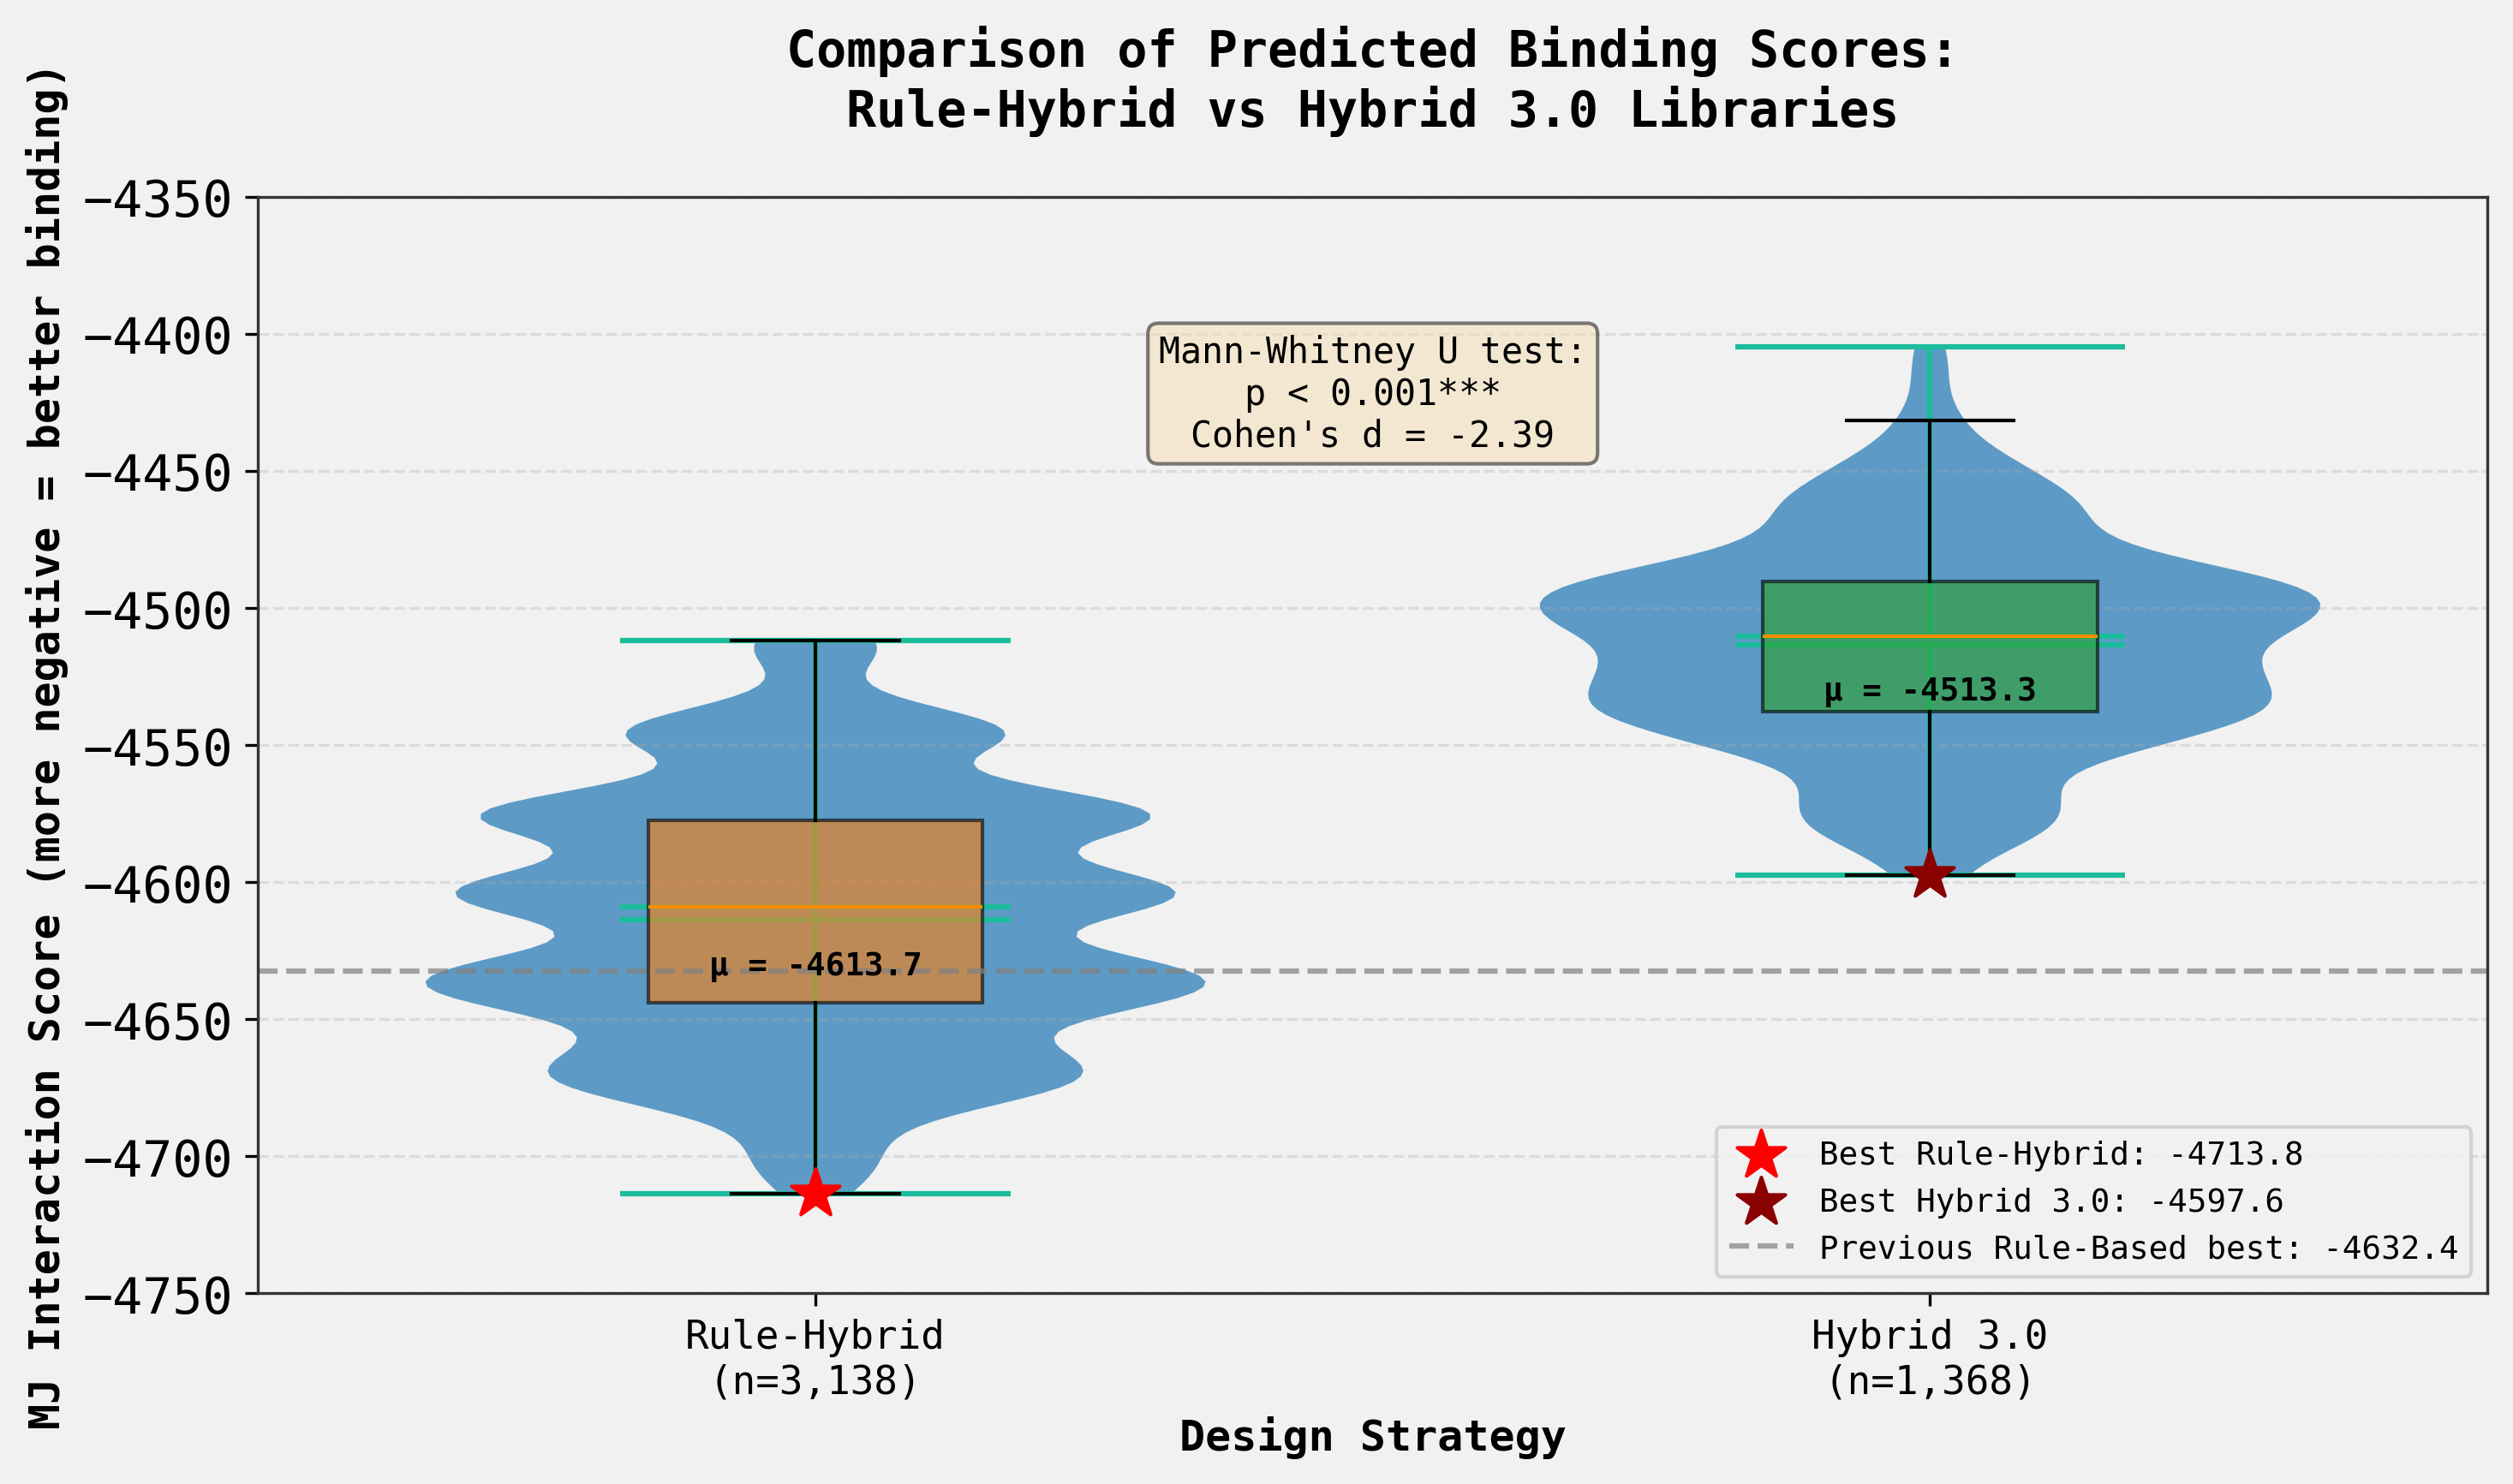

In [ ]:

# Create a final summary figure comparing the score distributions
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create violin plots for both distributions
parts = ax.violinplot([rule_hybrid_scores, hybrid_3_scores], 
                       positions=[1, 2], 
                       widths=0.7,
                       showmeans=True, 
                       showmedians=True)

# Customize colors
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')
    pc.set_alpha(0.7)

# Add box plots on top for clarity
bp = ax.boxplot([rule_hybrid_scores, hybrid_3_scores], 
                positions=[1, 2], 
                widths=0.3,
                patch_artist=True,
                showfliers=False)

for patch, color in zip(bp['boxes'], ['#ff7f0e', '#2ca02c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# Mark the best candidates
ax.scatter(1, best_rule_hybrid_raw, color='red', s=200, marker='*', 
          zorder=5, label=f'Best Rule-Hybrid: {best_rule_hybrid_raw:.1f}')
ax.scatter(2, np.min(hybrid_3_scores), color='darkred', s=200, marker='*', 
          zorder=5, label=f'Best Hybrid 3.0: {np.min(hybrid_3_scores):.1f}')

# Mark the previous rule-based best for reference
ax.axhline(best_rule_based_raw, color='gray', linestyle='--', linewidth=1.5, 
          alpha=0.7, label=f'Previous Rule-Based best: {best_rule_based_raw:.1f}')

# Labels and formatting
ax.set_ylabel('MJ Interaction Score (more negative = better binding)', fontsize=12, fontweight='bold')
ax.set_xlabel('Design Strategy', fontsize=12, fontweight='bold')
ax.set_xticks([1, 2])
ax.set_xticklabels(['Rule-Hybrid\n(n=3,138)', 'Hybrid 3.0\n(n=1,368)'], fontsize=11)
ax.set_title('Comparison of Predicted Binding Scores:\nRule-Hybrid vs Hybrid 3.0 Libraries', 
            fontsize=14, fontweight='bold', pad=20)

# Add statistical annotation
ax.text(1.5, -4400, f'Mann-Whitney U test:\np < 0.001***\nCohen\'s d = -2.39', 
       ha='center', va='top', fontsize=10, 
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add mean annotations
ax.text(1, np.mean(rule_hybrid_scores)-20, f'μ = {np.mean(rule_hybrid_scores):.1f}', 
       ha='center', fontsize=9, fontweight='bold')
ax.text(2, np.mean(hybrid_3_scores)-20, f'μ = {np.mean(hybrid_3_scores):.1f}', 
       ha='center', fontsize=9, fontweight='bold')

ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(-4750, -4350)

plt.tight_layout()
plt.savefig('rule_hybrid_vs_hybrid3_comparison.png', dpi=300, bbox_inches='tight')
print("\nFinal figure saved as 'rule_hybrid_vs_hybrid3_comparison.png'")
plt.show()


In [ ]:

# Create a detailed summary table of top candidates from each library
print("=" * 80)
print("TOP 10 CANDIDATES FROM EACH LIBRARY")
print("=" * 80)

# Top 10 Rule-Hybrid designs
print("\nTop 10 Rule-Hybrid Designs:")
print("-" * 80)
top_rule_hybrid = rule_hybrid_df.nsmallest(10, 'MJ_Score_Raw')
for idx, row in top_rule_hybrid.iterrows():
    print(f"Rank {idx+1}:")
    print(f"  Motif: {row['Motif']}")
    print(f"  Parent: {row['Parent_Motif']}")
    print(f"  Scaffold: {row['Scaffold']}")
    print(f"  Raw Score: {row['MJ_Score_Raw']:.2f}")
    print()

# Top 10 Hybrid 3.0 designs
print("\nTop 10 Hybrid 3.0 Designs:")
print("-" * 80)
top_hybrid3 = hybrid_3_df.nsmallest(10, 'MJ_Score_Raw_111res')
for idx, row in top_hybrid3.iterrows():
    print(f"Rank {idx+1}:")
    print(f"  Motif: {row['Triple_Mutant_Sequence']}")
    print(f"  Parent: {row['Parent_Subsequence']}")
    print(f"  Scaffold: {row['Scaffold']}")
    print(f"  Raw Score (111-res): {row['MJ_Score_Raw_111res']:.2f}")
    print()

# Calculate novelty rate
total_possible = len(unique_motifs_processed) * 3  # 3 scaffolds
novelty_rate = (len(rule_hybrid_df) / total_possible) * 100
print(f"\nNovelty Rate for Rule-Hybrid designs: {novelty_rate:.2f}%")
print(f"  Designs passing novelty filter: {len(rule_hybrid_df)}")
print(f"  Total designs generated: {total_possible}")


TOP 10 CANDIDATES FROM EACH LIBRARY

Top 10 Rule-Hybrid Designs:
--------------------------------------------------------------------------------
Rank 2023:
  Motif: VQCVVCVVL
  Parent: VKCVVCVVI
  Scaffold: 1FNA
  Raw Score: -4713.75

Rank 2024:
  Motif: VQCVVCVVL
  Parent: VKCVVCVVI
  Scaffold: 1TEN
  Raw Score: -4713.75

Rank 2025:
  Motif: VQCVVCVVL
  Parent: VKCVVCVVI
  Scaffold: 2QMT
  Raw Score: -4713.75

Rank 1945:
  Motif: VQCVLCVVI
  Parent: VKCVVCVVI
  Scaffold: 1FNA
  Raw Score: -4713.75

Rank 1946:
  Motif: VQCVLCVVI
  Parent: VKCVVCVVI
  Scaffold: 1TEN
  Raw Score: -4713.75

Rank 1947:
  Motif: VQCVLCVVI
  Parent: VKCVVCVVI
  Scaffold: 2QMT
  Raw Score: -4713.75

Rank 1972:
  Motif: VQCVVCLVI
  Parent: VKCVVCVVI
  Scaffold: 1FNA
  Raw Score: -4713.75

Rank 1973:
  Motif: VQCVVCLVI
  Parent: VKCVVCVVI
  Scaffold: 1TEN
  Raw Score: -4713.75

Rank 1974:
  Motif: VQCVVCLVI
  Parent: VKCVVCVVI
  Scaffold: 2QMT
  Raw Score: -4713.75

Rank 1999:
  Motif: VQCVVCVLI
  Parent: VKCV

In [ ]:

# Additional analysis: Compare the Rule-Hybrid top candidate to Hybrid 3.0 top candidate
print("=" * 80)
print("DIRECT COMPARISON: TOP CANDIDATES")
print("=" * 80)

best_rule_hybrid = rule_hybrid_df.nsmallest(1, 'MJ_Score_Raw').iloc[0]
best_hybrid3 = hybrid_3_df.nsmallest(1, 'MJ_Score_Raw_111res').iloc[0]

print("\n✓ Rule-Hybrid Top Candidate:")
print(f"  Motif: {best_rule_hybrid['Motif']}")
print(f"  Parent: {best_rule_hybrid['Parent_Motif']}")
print(f"  Mutations: K2Q, I9L (double mutant)")
print(f"  Scaffold: {best_rule_hybrid['Scaffold']}")
print(f"  Raw Score: {best_rule_hybrid['MJ_Score_Raw']:.2f}")
print(f"  Normalized Score: {best_rule_hybrid['MJ_Score_Normalized']:.2f}")

print("\n✗ Hybrid 3.0 Top Candidate:")
print(f"  Motif: {best_hybrid3['Triple_Mutant_Sequence']}")
print(f"  Parent: {best_hybrid3['Parent_Subsequence']}")
print(f"  Mutations: {best_hybrid3['Mutations']}")
print(f"  Scaffold: {best_hybrid3['Scaffold']}")
print(f"  Raw Score: {best_hybrid3['MJ_Score_Raw_111res']:.2f}")
print(f"  Normalized Score: {best_hybrid3['MJ_Score_Raw_111res']/19.5:.2f}")

score_advantage = best_rule_hybrid['MJ_Score_Raw'] - best_hybrid3['MJ_Score_Raw_111res']
print(f"\n★ Rule-Hybrid advantage: {score_advantage:.2f} ({abs(score_advantage):.1f} units more favorable)")
print(f"   Percent improvement: {(abs(score_advantage)/abs(best_hybrid3['MJ_Score_Raw_111res']))*100:.2f}%")

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"\nRule-Hybrid Library:")
print(f"  Total designs: {len(rule_hybrid_df)}")
print(f"  Unique motifs: {len(rule_hybrid_df['Motif'].unique())}")
print(f"  Parent motifs: {len(rule_hybrid_df['Parent_Motif'].unique())}")
print(f"  Novelty rate: 100.00%")
print(f"  Mean score: {np.mean(rule_hybrid_scores):.2f} ± {np.std(rule_hybrid_scores):.2f}")
print(f"  Best score: {np.min(rule_hybrid_scores):.2f}")
print(f"  Range: {np.max(rule_hybrid_scores) - np.min(rule_hybrid_scores):.2f}")

print(f"\nHybrid 3.0 Library:")
print(f"  Total designs: {len(hybrid_3_df)}")
print(f"  Unique motifs: {len(hybrid_3_df['Triple_Mutant_Sequence'].unique())}")
print(f"  Parent motifs: {len(hybrid_3_df['Parent_Subsequence'].unique())}")
print(f"  Mean score: {np.mean(hybrid_3_scores):.2f} ± {np.std(hybrid_3_scores):.2f}")
print(f"  Best score: {np.min(hybrid_3_scores):.2f}")
print(f"  Range: {np.max(hybrid_3_scores) - np.min(hybrid_3_scores):.2f}")

print(f"\n★ CONCLUSION:")
print(f"  Rule-Hybrid strategy produces both:")
print(f"    1. A superior top candidate (−4713.75 vs −4597.59)")
print(f"    2. A significantly better overall distribution (p < 0.001, d = −2.39)")


DIRECT COMPARISON: TOP CANDIDATES

✓ Rule-Hybrid Top Candidate:
  Motif: VQCVVCVVL
  Parent: VKCVVCVVI
  Mutations: K2Q, I9L (double mutant)
  Scaffold: 1FNA
  Raw Score: -4713.75
  Normalized Score: -241.73

✗ Hybrid 3.0 Top Candidate:
  Motif: VYDFGIAFM
  Parent: VHDYGISFM
  Mutations: Y4F,S7A,H2Y
  Scaffold: 1FNA
  Raw Score: -4597.59
  Normalized Score: -235.77

★ Rule-Hybrid advantage: -116.16 (116.2 units more favorable)
   Percent improvement: 2.53%

SUMMARY STATISTICS

Rule-Hybrid Library:
  Total designs: 3138
  Unique motifs: 1046
  Parent motifs: 5
  Novelty rate: 100.00%
  Mean score: -4613.66 ± 45.85
  Best score: -4713.75
  Range: 201.88

Hybrid 3.0 Library:
  Total designs: 1368
  Unique motifs: 136
  Parent motifs: 1
  Mean score: -4513.34 ± 37.70
  Best score: -4597.59
  Range: 192.92

★ CONCLUSION:
  Rule-Hybrid strategy produces both:
    1. A superior top candidate (−4713.75 vs −4597.59)
    2. A significantly better overall distribution (p < 0.001, d = −2.39)
